Description: solution to Case Study 1

Version: 1.4.1.20210401

Author: Haodong Liu and Jichen Zhao

Last editors: Jichen Zhao

# Case Study 1

This case study is about predicting the development of central neuropathic pain (CNP) among individuals with spinal cord injury (SCI) from a provided electroencephalogram (EEG) dataset.

**The task** involves devising a feature engineering strategy which, in combination with your classifier, maximises leave-one-subject-out cross-validation (CV) accuracy.

**The objective measure** is the CV accuracy, sensitivity, and specificity.

## 1. Preparation

### 1.1. Importing Modules

This case study is accomplished in the context of using [`scikit-learn`](https://scikit-learn.org/stable/) as a tool to explore relevant techniques.

In [1]:
from typing import Tuple
import warnings

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np


warnings.filterwarnings('ignore', category = DeprecationWarning)

### 1.2. Loading Data

The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
- **48 electrodes:** electrical activity of the brain at 250 Hz
- **2 classes:** subject will / will not develop neuropathic pain within 6 months
- **18 subjects:** 10 developed pain and 8 did not develop pain
- The data has already undergone some preprocessing:
  - Signal denoising and normalisation
  - Temporal segmentation
  - Frequency band power estimation
  - Normalisation with respect to total band power
  - Features include normalised alpha, beta, theta band power while EC, EO, and taking the ratio of EC/EO.
- The data is provided in a single table (`data.csv`) consisting of:
  - **180 rows (18 subjects x 10 repetitions)**, each containing **432 columns (9 features x 48 electrodes)**
  - Rows are in subject major order (i.e., rows 0-9 are all samples from subject 0, etc.)
  - Columns are in feature type major order (i.e., columns 0-47 are alpha band power, EC, electrodes 0-47, etc.)
  - Feature identifiers for all columns are stored in `feature_names.csv`
  - `labels.csv` defines the corresponding class (0 or 1) to each row in `data.csv`

In [2]:
X = np.loadtxt('data.csv', delimiter = ',') 
y = np.loadtxt('labels.csv', delimiter = ',')
print('Number of samples:', len(y))  # Equal to "X.shape[0]".
print('Number of features:', X.shape[1])

Number of samples: 180
Number of features: 432


### 1.3. Defining a CV Strategy

Leaving one subject out means removing a contiguous block of 10 rows from the data to hold out a different participant. Hence, the CV strategy can be defined using the [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class.

In [3]:
n_folds = 18  # This number is defined as per the data's characteristics.
subject_cv = KFold(n_splits = n_folds)  # Separated by participants to ensure data of 17 participants as training data and data of the left one participant as test data in each CV fold.

### 1.4. Building a Classifier

The [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class is used for building a logistic regression (LR) classifier. The `liblinear` solver is used due to a small dataset and a binary classification problem.

In [4]:
lr = LogisticRegression(random_state = 0, solver = 'liblinear')

## 2. Feature Scaling

The [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class performs **standardisation/Z-score normalisation**, while the [`MinMaxScaler`]() class performs **min-max normalisation**.

In [5]:
ss = StandardScaler()
mms = MinMaxScaler()

## 3. Feature Selection/Extraction

The solution to this case study mainly focuses on selecting group features (i.e., features grouped into 48 electrodes/9 feature types) rather than individual features. The following functions are defined to reuse code.

In [6]:
n_electrodes = 48  # The total number of electrodes.
n_types = 9  # The total number of feature types.


def transform_X(filter_features: np.ndarray, eliminate: bool = True, is_electrode: bool = True) -> np.ndarray:
    '''
    Reduce X to selected features.

    Parameters
    ----------
    filter_features : a NumPy array of indexes of group features to filter
    eliminate : a flag indicating whether features are eliminated or not (i.e., selected)
    is_electrode : a flag indicating whether the group feature type is electrode or not (i.e., feature type)

    Returns
    -------
    X_new : X reduced to selected features
    '''

    mask = np.zeros(X.shape[1], dtype = bool)  # Define a mask for eliminating/selecting features.
    mask_features = np.array([filter_features + i * n_electrodes for i in range(n_types)] if is_electrode else [filter_features * n_electrodes + i for i in range(n_electrodes)])  # Get all indexes of eliminated/selected features from the group feature indexes.
    mask[mask_features.flatten()] = True
    return X[:, ~mask if eliminate else mask]


def plot_trend(y_vals: list or np.ndarray, x_label: str, y_label: str = 'Mean CV accuracy', title: str = 'Accuracy Trend', x_start_0: bool = True) -> None:
    '''
    Plot a trend.

    Parameters
    ----------
    y_vals : a list or a NumPy array of y-axis values
    x_label : the x-axis label
    y_label : the y-axis label
    title : the plotted figure's title
    x_start_0 : a flag indicating whether the x-axis range starts from 0 or not (i.e., 1)
    '''

    x_start = 0 if x_start_0 else 1
    plt.plot(np.arange(x_start, len(y_vals) + x_start), y_vals)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### 3.1. Filter-Based Methods

The [`f_classif()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) function ranks group features in each CV fold based on analysis of variance (ANOVA). P-values are better if smaller.

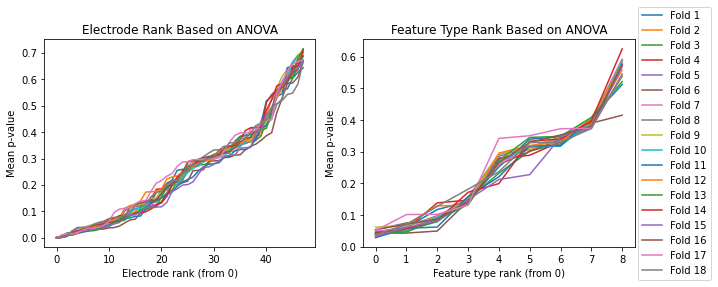

In [7]:
ranks_electrodes = []  # A list of each CV fold's electrode rank.
ranks_types = []  # A list of each CV fold's feature type rank.
_, ax = plt.subplots(1, 2, figsize = (10, 4))

for i, indexes in enumerate(subject_cv.split(X)):
    _, p_vals = f_classif(X[indexes[0]], y[indexes[0]])  # Get each feature's p-values.

    p_vals_electrodes = np.reshape(p_vals, (n_electrodes, -1))
    p_vals_electrodes = np.mean(p_vals_electrodes, axis = 1)  # Get each electrode's mean p-values.
    rank_electrodes = np.argsort(p_vals_electrodes)  # Rank each electrode.
    ranks_electrodes.append(rank_electrodes)
    ax[0].plot(p_vals_electrodes[rank_electrodes], label = 'Fold ' + str(i + 1))

    p_vals_types = np.reshape(p_vals, (n_types, -1))
    p_vals_types = np.mean(p_vals_types, axis = 1)  # Get each feature type's mean p-values.
    rank_types = np.argsort(p_vals_types)  # Rank each feature type.
    ranks_types.append(rank_types)
    ax[1].plot(p_vals_types[rank_types], label = 'Fold ' + str(i + 1))

ax[0].set_title('Electrode Rank Based on ANOVA')
ax[0].set_xlabel('Electrode rank (from 0)')
ax[0].set_ylabel('Mean p-value')
ax[1].set_title('Feature Type Rank Based on ANOVA')
ax[1].set_xlabel('Feature type rank (from 0)')
ax[1].set_ylabel('Mean p-value')
plt.legend(bbox_to_anchor = (1.3, 0.5), loc = 'right')
plt.tight_layout()
plt.show()

Based on the rank results, **`k` best scoring electrodes/feature types** are selected for each CV fold. Here the number of selected group features `k` is tuned with CV. The [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function is used to compute the CV accuracy. The following function is defined to reuse code.

**NOTE: Although the selected features in each CV fold may be different, data dimensionality controlled by `k` should be the same.**

In [8]:
def filter_k(model: Pipeline, is_electrode: bool = True) -> Tuple[np.ndarray, int, list]:
    '''
    Select k best scoring group features for each CV fold.

    Parameters
    ----------
    model : a model to train
    is_electrode : a flag indicating whether the group feature type is electrode or not (i.e., feature type)

    Returns
    -------
    Xs : X reduced to selected group features for each CV fold.
    k : the number of selected group features
    '''

    ranks = ranks_electrodes if is_electrode else ranks_types
    accuracy_list = []

    for k in range(1, (n_electrodes if is_electrode else n_types) + 1):
        prediction_list = []  # A list of each CV fold's predictions.

        for i, indexes in enumerate(subject_cv.split(X)):
            X_temp = transform_X(ranks[i][:k], False, is_electrode)  # Use my function to reduce X to selected features for the CV fold.
            model.fit(X_temp[indexes[0]], y[indexes[0]])
            prediction_list.append(model.predict(X_temp[indexes[1]]))
        
        y_pred = np.ravel(prediction_list)
        accuracy_list.append(accuracy_score(y, y_pred))

    k = np.argmax(accuracy_list) + 1
    Xs = np.array([transform_X(ranks[i][:k], False, is_electrode) for i in range(n_folds)])  # Use my function to reduce X to selected features for each CV fold.
    plot_trend(accuracy_list, 'K', x_start_0 = False)  # Use my function to plot the accuracy trend.
    group_size = n_types if is_electrode else n_electrodes
    print('Number of selected features (k * group size): %i * %i = %i' % (k, group_size, k * group_size))
    return Xs

### 3.2. Wrapper-Based Methods

**Backward feature elimination/Forward feature selection** is implemented to eliminate/select group features. The [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function can help. The following functions are defined to reuse code.

**NOTE: As per these methods' implementation, feature selection, and model training and testing are all done in the `wrapper()` function. Although it returns reduced `X`, it does not mean that test data is used to select features. The returns are mainly for repeating model evaluation in the corresponding section to compute the sensitivity and the specificity.**

In [9]:
def wrapper(model: Pipeline, is_backward: bool = True, is_electrode: bool = True) -> np.ndarray:
    '''
    Perform backward/forward feature selection to select the best subset of group features, and reduce X to selected group features.

    Parameters
    ----------
    model : a model to train
    is_backward : a flag indicating whether the selection direction is backward or not (i.e., forward)
    is_electrode : a flag indicating whether the group feature type is electrode or not (i.e., feature type)

    Returns
    -------
    X_new : X reduced to selected group features
    '''

    n_groups = n_electrodes if is_electrode else n_types  # The number of group features.
    best_score = np.mean(cross_val_score(model, X, y, cv = subject_cv, scoring = 'accuracy')) if is_backward else 0
    score_list = [best_score]
    accuracy_list = []
    excluded_groups = []  # A list of the eliminated/selected group features.

    # Loop for at most n_groups times to eliminate/select a group feature.
    for _ in range(n_groups):
        iter_accuracy_list = []

        # Loop to evaluate the performance assuming a group feature is eliminated/selected.
        for i in range(n_groups):
            # Ignore this loop because the group feature has already been eliminated/selected.
            if i in excluded_groups:
                iter_accuracy_list.append(0)  # Set accuracy to 0 to visualise each iteration's mean CV accuracy better.
                continue
            
            filter_features = excluded_groups.copy()
            filter_features.append(i)  # Assume a group feature is eliminated/selected.
            X_temp = transform_X(np.array(filter_features), is_backward, is_electrode)  # Use my function to reduce X to selected features for CV.
            iter_accuracy_list.append(np.mean(cross_val_score(model, X_temp, y, cv = subject_cv, scoring = 'accuracy')))

        accuracy_list.append(iter_accuracy_list)
        max_accuracy = np.max(iter_accuracy_list)

        # End the entire process if eliminating/selecting a feature would degrade performance.
        if best_score > max_accuracy:
            break

        best_score = max_accuracy
        score_list.append(best_score)
        excluded_groups.append(np.argmax(iter_accuracy_list))  # Append the index of the group feature with the best CV accuracy to the list of eliminated/selected group features.

    X_new = transform_X(np.array(excluded_groups), is_backward, is_electrode)  # Use my function to finally reduce X to selected features.
    n_groups_excluded = len(excluded_groups)
    n_groups_selected = (n_groups - n_groups_excluded) if is_backward else n_groups_excluded
    plot_1st_last(accuracy_list, score_list, n_groups)  # Use my function to plot each group feature's mean CV accuracy for the first and last step.
    plot_trend(score_list, 'Iteration index')  # Use my function to plot the accuracy trend.
    print('Number of selected features (selected groups * group size): %i * %i = %i' % (n_groups_selected, n_types if is_electrode else n_electrodes, X_new.shape[1]))
    return X_new


def plot_1st_last(accuracy_list: list, score_list: list, n_groups: int = n_electrodes) -> None:
    '''
    Plot each group feature's mean CV accuracy for the first and last step.

    Parameters
    ----------
    accuracy_list : a list of accuracy lists of each iteration
    score_list : a list of mean CV accuracy of each iteration
    n_groups : the number of group features
    '''

    _, ax = plt.subplots(1, 2, figsize = (12 if n_groups == n_electrodes else 8, 4))

    for i in range(2):
        ax[i].bar(np.arange(n_groups), accuracy_list[-i])  # Plot a bar chart showing the mean CV accuracy of each group feature for the first or last step.
        ax[i].axhline(score_list[-i], color = 'r', label = 'Baseline')  # Plot a horizontal line indicating mean CV accuracy of this step.
        ax[i].set_title(('1st' if i == 0 else 'Last') + ' step')
        ax[i].set_xlabel('Electrode' if n_groups == n_electrodes else 'Feature type')
        ax[i].set_ylabel('Mean CV accuracy')

        # Narrow down y-axis limits properly to make the chart look better.
        plot_values = accuracy_list[-i].copy()
        plot_values.append(score_list[-i])
        y_max = np.max(plot_values) + 0.01
        ax[i].set_ylim(np.min(np.ma.masked_equal(plot_values, 0, False)) - 0.01, y_max if y_max <= 1 else 1)

    plt.legend(bbox_to_anchor = (1.3 if n_groups == n_electrodes else 1.5, 0.5), loc = 'right')
    plt.tight_layout()
    plt.show()

### 3.3. Embedded Methods

Individual features are selected using the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) class to perform **L1-based feature selection**.

In [10]:
sfm = SelectFromModel(LogisticRegression(penalty = 'l1', random_state = 0, solver = 'liblinear'))

### 3.4. Principal Component Analysis (PCA)

Individual features are extracted using the [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class. A function is defined to reuse code. The number of extracted principal components (PC) is determined using CV with the help of the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class.

In [11]:
def pca(scaler: StandardScaler or MinMaxScaler = ss) -> Pipeline:
    '''
    Form a model containing PCA with the suitable number of extracted PC.

    Parameters
    ----------
    scaler : the scaler for feature scaling

    Returns
    -------
    pipe : a model to train
    '''

    model = Pipeline([('scaler', scaler), ('pca', PCA()), ('clf', lr)])
    search = GridSearchCV(model, {'pca__n_components': np.arange(1, 171)}, cv = subject_cv).fit(X, y)  # The maximum number of PC is 170 due to the CV strategy and the range of the number defined by the class.
    plot_trend(search.cv_results_['mean_test_score'], 'Number of PC', x_start_0 = False)  # Use my function to plot the accuracy trend.
    n_pc = search.best_params_['pca__n_components']
    print('Number of extracted PC:', n_pc)
    return Pipeline([('scaler', scaler), ('pca', PCA(n_pc)), ('clf', lr)])

## 4. Training and Evaluation

The training and evaluation experiments are generally divided into 2 groups - the standardisation group and the min-max normalisation group. A different feature scaling method is the primary difference between these groups. Each group has an experiment of using the original data as a control for comparison. There are 9 experiments in each group since 8 feature selection/extraction methods are explored in this solution. A function can be defined to reuse code. The [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) function is used to compute the sensitivity/recall/true positive rate (TPR) and the specificity/false positive rate (FPR).

In [12]:
# Additional models and a result recorder required by the standardisation group.
pipe_ss = Pipeline([('scaler', ss), ('clf', lr)])
pipe_ss_sfm = Pipeline([('scaler', ss), ('sfm', sfm), ('clf', lr)])
results_ss = np.zeros((3, 9))

# Additional models and a result recorder required by the min-max normalisation group.
pipe_mms = Pipeline([('scaler', mms), ('clf', lr)])
pipe_mms_sfm = Pipeline([('scaler', mms), ('sfm', sfm), ('clf', lr)])
results_mms = np.zeros((3, 9))


def evaluate_model(model: LogisticRegression or Pipeline = lr, X_new: np.ndarray = X, is_filter: bool = False) -> Tuple[float, float, float]:
    '''
    Compute the CV accuracy, sensitivity, and specificity.

    Parameters
    ----------
    model : a model to train
    X_new : X reduced to selected features
    is_filter : a flag indicating whether a filter-based feature selection method is used or not

    Returns
    -------
    accuracy : mean CV accuracy
    sensitivity : TPR
    specificity : FPR
    '''

    X_temp = X_new
    prediction_list = []  # A list of each CV fold's predictions.
    
    # Train and evaluate the model on each CV fold.
    for i, indexes in enumerate(subject_cv.split(X)):
        if is_filter:
            X_temp = X_new[i]

        model.fit(X_temp[indexes[0]], y[indexes[0]])
        prediction_list.append(model.predict(X_temp[indexes[1]]))

    y_pred = np.ravel(prediction_list)
    accuracy = accuracy_score(y, y_pred)
    sensitivity = recall_score(y, y_pred)
    specificity = recall_score(y, y_pred, pos_label = 0)
    print('Accuracy: %.1f%%' % (accuracy * 100))
    print('Sensitivity: %.1f%%' % (sensitivity * 100))
    print('Specificity: %.1f%%' % (specificity * 100))
    return accuracy, sensitivity, specificity


def plot_results(results: np.ndarray, is_ss: bool = True) -> None:
    '''
    Plot each strategy's accuracy, sensitivity, and specificity in an experiment group.

    Parameters
    ----------
    results : a NumPy array of evaluation results
    is_ss : a flag indicating whether the results belong to the standardisation group or not (i.e., the min-max normalisation group)
    '''

    xticks_locs = np.arange(results.shape[1])
    xticks_labels = ('Original data', 'K best electrode', 'K best feature type', 'Backward electrode', 'Forward electrode', 'Backward feature type', 'Forward feature type', 'L1-based', 'PCA')
    plt.figure(figsize = (8, 4))
    plt.axhline(results[0, 0], color = 'b', label = 'Accuracy baseline')  # Plot a horizontal line indicating the accuracy of the model trained and evaluated with the original data.
    plt.axhline(results[1, 0], color = 'k', label = 'Sensitivity baseline')  # Plot a horizontal line indicating the sensitivity of the model trained and evaluated with the original data.
    plt.axhline(results[2, 0], color = 'g', label = 'Specificity baseline')  # Plot a horizontal line indicating the specificity of the model trained and evaluated with the original data.
    plt.bar(xticks_locs - 0.2, results[0], color = 'orange', label = 'Accuracy', width = 0.2)
    plt.bar(xticks_locs, results[1], color = 'grey', label = 'Sensitivity', width = 0.2)
    plt.bar(xticks_locs + 0.2, results[2], color = 'plum', label = 'Specificity', width = 0.2)
    plt.title(('Standardisation Group' if is_ss else 'Min-Max Normalisation Group') + ': Accuracy, Sensitivity, and Specificity')
    plt.xticks(xticks_locs, xticks_labels, rotation = 90)

    # Narrow down y-axis limits properly to make the chart look better.
    y_max = np.max(results[:3]) + 0.01
    plt.ylim(np.min(results[:3]) - 0.01, y_max if y_max <= 1 else 1)
    plt.legend(bbox_to_anchor = (1.35, 0.5), loc = 'right')
    plt.show()

Experiment 1: no feature scaling and selection/extraction (i.e., **the original data**).

In [13]:
acc_base, tpr_base, fpr_base = evaluate_model()  # Use my function to train and evaluate a model.
results_ss[0, 0] = results_mms[0, 0] = acc_base
results_ss[1, 0] = results_mms[1, 0] = tpr_base
results_ss[2, 0] = results_mms[2, 0] = fpr_base

Accuracy: 86.1%
Sensitivity: 83.8%
Specificity: 88.0%


The following experiments use a feature engineering strategy (one of the 2 feature scaling methods and one of the 8 feature selection/extraction methods).

Experiment 2: **`k` best scoring electrodes**.

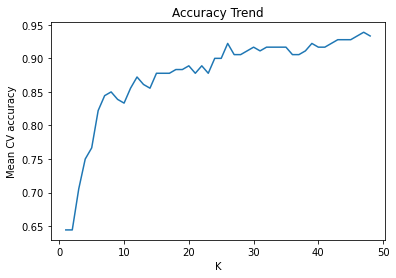

Number of selected features (k * group size): 47 * 9 = 423
Accuracy: 93.9%
Sensitivity: 93.8%
Specificity: 94.0%


In [14]:
# The standardisation group.
Xs_kbe = filter_k(pipe_ss)  # Use my function to select k best scoring electrodes for each CV fold.
results_ss[0, 1], results_ss[1, 1], results_ss[2, 1] = evaluate_model(pipe_ss, Xs_kbe, True)  # Use my function to train and evaluate a model.

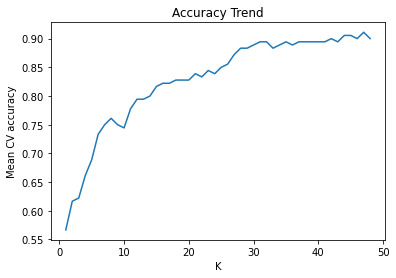

Number of selected features (k * group size): 47 * 9 = 423
Accuracy: 91.1%
Sensitivity: 87.5%
Specificity: 94.0%


In [15]:
# The min-max normalisation group.
Xs_kbe = filter_k(pipe_mms)  # Use my function to select k best scoring electrodes for each CV fold.
results_mms[0, 1], results_mms[1, 1], results_mms[2, 1] = evaluate_model(pipe_mms, Xs_kbe, True)  # Use my function to train and evaluate a model.

Experiment 3: **`k` best scoring feature types**.

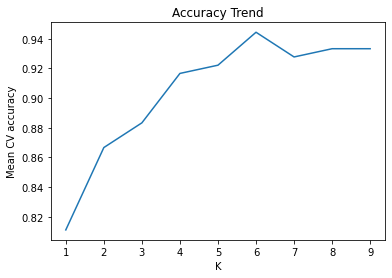

Number of selected features (k * group size): 6 * 48 = 288
Accuracy: 94.4%
Sensitivity: 95.0%
Specificity: 94.0%


In [16]:
# The standardisation group.
Xs_kbt = filter_k(pipe_ss, False)  # Use my function to select k best scoring feature types for each CV fold.
results_ss[0, 2], results_ss[1, 2], results_ss[2, 2] = evaluate_model(pipe_ss, Xs_kbt, True)  # Use my function to train and evaluate a model.

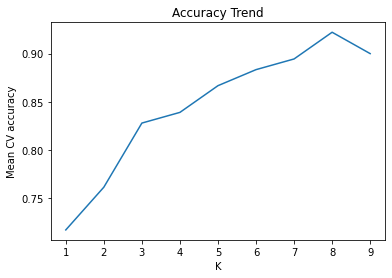

Number of selected features (k * group size): 8 * 48 = 384
Accuracy: 92.2%
Sensitivity: 88.8%
Specificity: 95.0%


In [17]:
# The min-max normalisation group.
Xs_kbt = filter_k(pipe_mms, False)  # Use my function to select k best scoring feature types for each CV fold.
results_mms[0, 2], results_mms[1, 2], results_mms[2, 2] = evaluate_model(pipe_mms, Xs_kbt, True)  # Use my function to train and evaluate a model.

Experiment 4: **backward electrode elimination**.

**NOTE: Executing this experiment can consume some time (approx. 2 minutes for the 1st cell and 1 minute for the 2nd but it depends on your CPU) due to data dimensionality and the method's mechanism.**

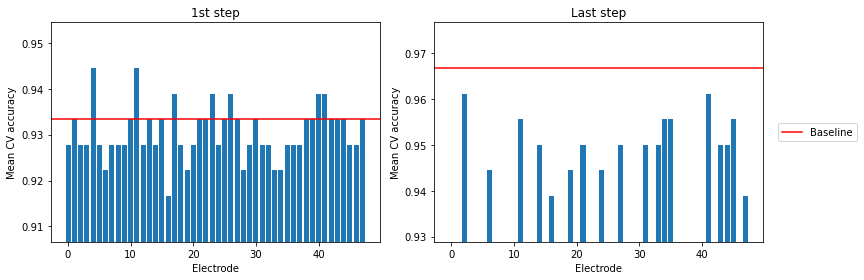

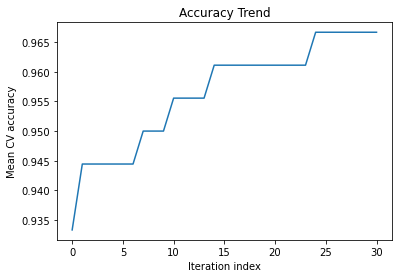

Number of selected features (selected groups * group size): 18 * 9 = 162
Accuracy: 96.7%
Sensitivity: 96.2%
Specificity: 97.0%


In [18]:
# The standardisation group.
X_eb = wrapper(pipe_ss)  # Use my function to select the best subset of electrodes.
results_ss[0, 3], results_ss[1, 3], results_ss[2, 3] = evaluate_model(pipe_ss, X_eb)  # Use my function to train and evaluate a model.

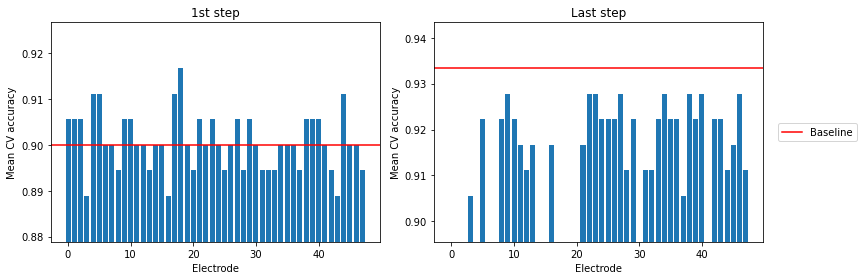

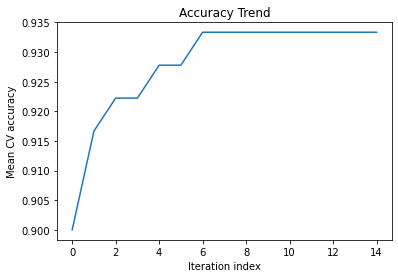

Number of selected features (selected groups * group size): 34 * 9 = 306
Accuracy: 93.3%
Sensitivity: 91.2%
Specificity: 95.0%


In [19]:
# The min-max normalisation group.
X_eb = wrapper(pipe_mms)  # Use my function to select the best subset of electrodes.
results_mms[0, 3], results_mms[1, 3], results_mms[2, 3] = evaluate_model(pipe_mms, X_eb)  # Use my function to train and evaluate a model.

Experiment 5: **forward electrode selection**.

**NOTE: Executing this experiment can consume some time (approx. 0.5 minute for each cell but it depends on your CPU) due to data dimensionality and the method's mechanism.**

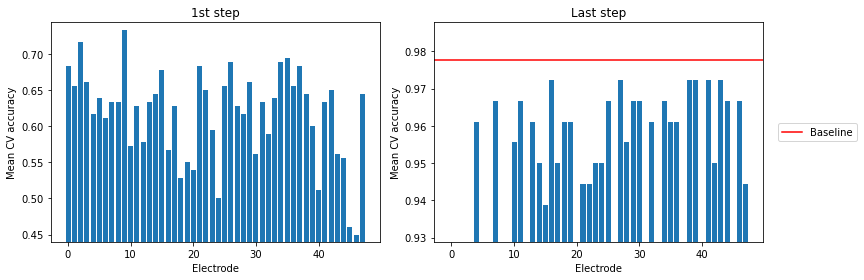

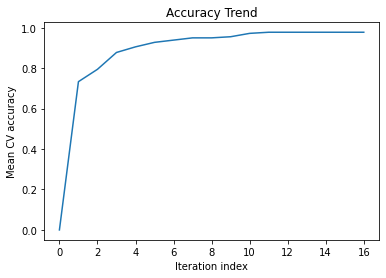

Number of selected features (selected groups * group size): 16 * 9 = 144
Accuracy: 97.8%
Sensitivity: 98.8%
Specificity: 97.0%


In [20]:
# The standardisation group.
X_ef = wrapper(pipe_ss, False)  # Use my function to select the best subset of electrodes.
results_ss[0, 4], results_ss[1, 4], results_ss[2, 4] = evaluate_model(pipe_ss, X_ef)  # Use my function to train and evaluate a model.

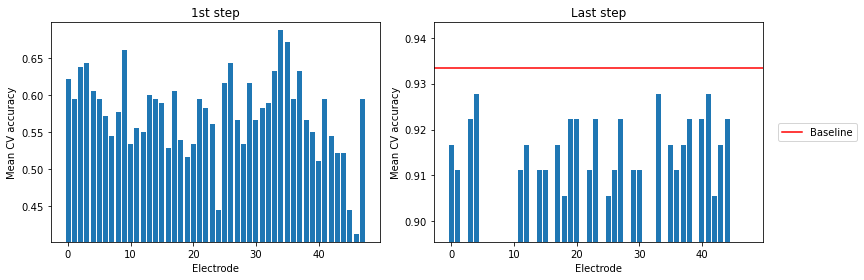

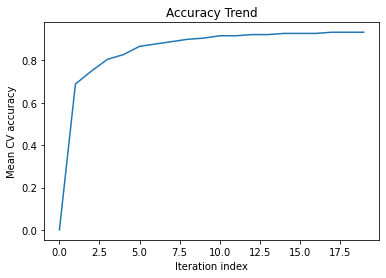

Number of selected features (selected groups * group size): 19 * 9 = 171
Accuracy: 93.3%
Sensitivity: 91.2%
Specificity: 95.0%


In [21]:
# The min-max normalisation group.
X_ef = wrapper(pipe_mms, False)  # Use my function to select the best subset of electrodes.
results_mms[0, 4], results_mms[1, 4], results_mms[2, 4] = evaluate_model(pipe_mms, X_ef)  # Use my function to train and evaluate a model.

Experiment 6: **backward feature type elimination**.

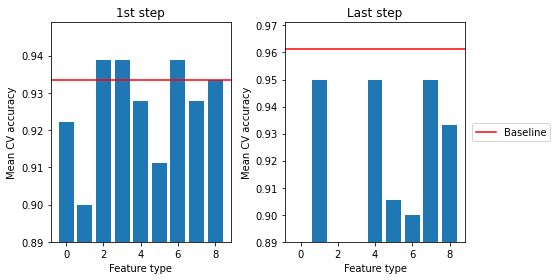

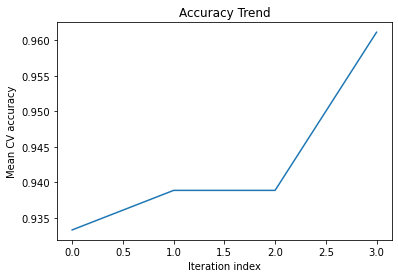

Number of selected features (selected groups * group size): 6 * 48 = 288
Accuracy: 96.1%
Sensitivity: 96.2%
Specificity: 96.0%


In [22]:
# The standardisation group.
X_ftb = wrapper(pipe_ss, is_electrode = False)  # Use my function to select the best subset of feature types.
results_ss[0, 5], results_ss[1, 5], results_ss[2, 5] = evaluate_model(pipe_ss, X_ftb)  # Use my function to train and evaluate a model.

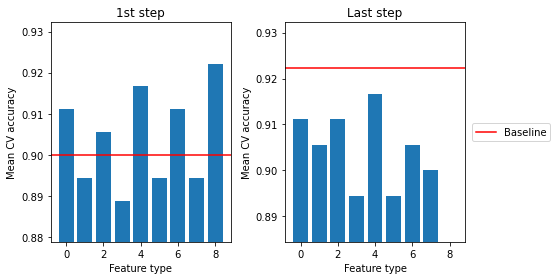

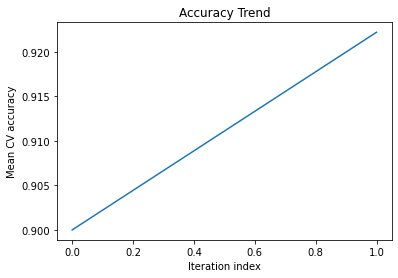

Number of selected features (selected groups * group size): 8 * 48 = 384
Accuracy: 92.2%
Sensitivity: 88.8%
Specificity: 95.0%


In [23]:
# The min-max normalisation group.
X_ftb = wrapper(pipe_mms, is_electrode = False)  # Use my function to select the best subset of feature types.
results_mms[0, 5], results_mms[1, 5], results_mms[2, 5] = evaluate_model(pipe_mms, X_ftb)  # Use my function to train and evaluate a model.

Experiment 7: **forward feature type selection**.

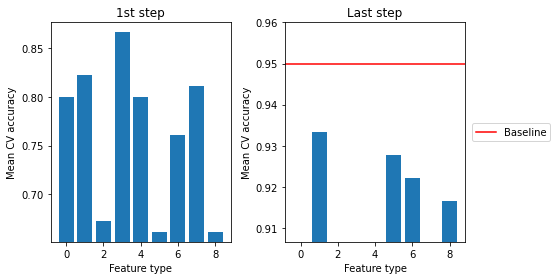

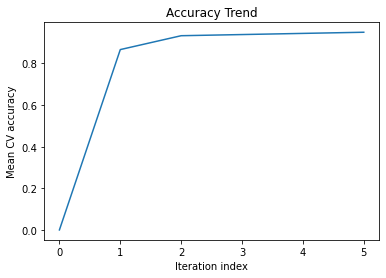

Number of selected features (selected groups * group size): 5 * 48 = 240
Accuracy: 95.0%
Sensitivity: 96.2%
Specificity: 94.0%


In [24]:
# The standardisation group.
X_ftf = wrapper(pipe_ss, False, False)  # Use my function to select the best subset of feature types.
results_ss[0, 6], results_ss[1, 6], results_ss[2, 6] = evaluate_model(pipe_ss, X_ftf)  # Use my function to train and evaluate a model.

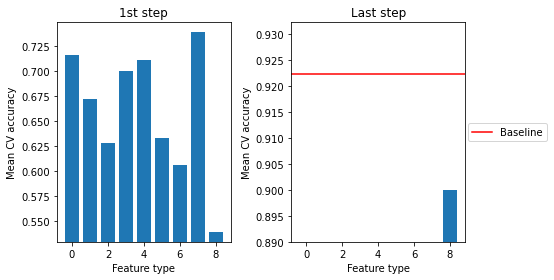

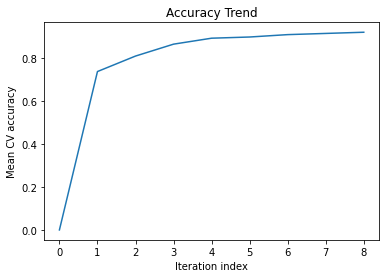

Number of selected features (selected groups * group size): 8 * 48 = 384
Accuracy: 92.2%
Sensitivity: 88.8%
Specificity: 95.0%


In [25]:
# The min-max normalisation group.
X_ftf = wrapper(pipe_mms, False, False)  # Use my function to select the best subset of feature types.
results_mms[0, 6], results_mms[1, 6], results_mms[2, 6] = evaluate_model(pipe_mms, X_ftf)  # Use my function to train and evaluate a model.

Experiment 8: **L1-based feature selection**.

In [26]:
results_ss[0, 7], results_ss[1, 7], results_ss[2, 7] = evaluate_model(pipe_ss_sfm)  # The standardisation group. Use my function to train and evaluate a model.

Accuracy: 92.2%
Sensitivity: 92.5%
Specificity: 92.0%


In [27]:
results_mms[0, 7], results_mms[1, 7], results_mms[2, 7] = evaluate_model(pipe_mms_sfm)  # The min-max normalisation group. Use my function to train and evaluate a model.

Accuracy: 87.2%
Sensitivity: 82.5%
Specificity: 91.0%


Experiment 9: **PCA**.

**NOTE: Executing this experiment can consume some time (approx. 0.5 minute for each cell but it depends on your CPU) due to the tuning of the number of PCs with CV.**

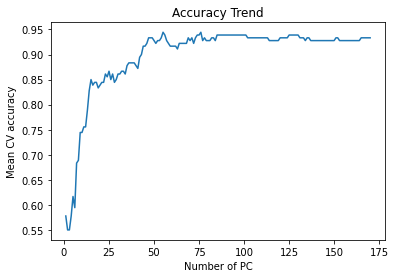

Number of extracted PC: 55
Accuracy: 94.4%
Sensitivity: 95.0%
Specificity: 94.0%


In [28]:
# The standardisation group.
pipe_ss_pca = pca()  # Use my function to form a model containing PCA with the suitable number of extracted PC.
results_ss[0, 8], results_ss[1, 8], results_ss[2, 8] = evaluate_model(pipe_ss_pca)  # Use my function to train and evaluate a model.

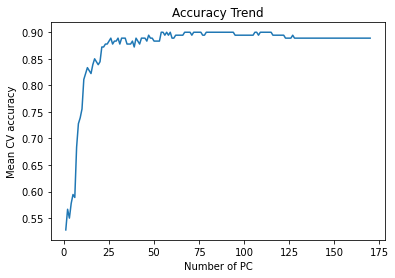

Number of extracted PC: 54
Accuracy: 90.0%
Sensitivity: 87.5%
Specificity: 92.0%


In [29]:
# The min-max normalisation group.
pipe_mms_pca = pca(mms)  # Use my function to form a model containing PCA with the suitable number of extracted PC.
results_mms[0, 8], results_mms[1, 8], results_mms[2, 8] = evaluate_model(pipe_mms_pca)  # Use my function to train and evaluate a model.

2 bar charts are plotted to view and compare each strategy's accuracy, sensitivity, and specificity in each experiment group.

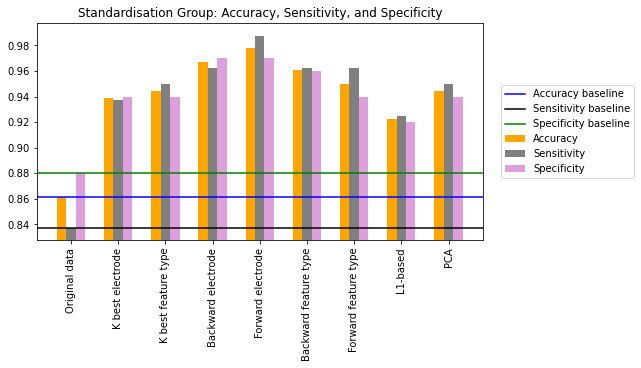

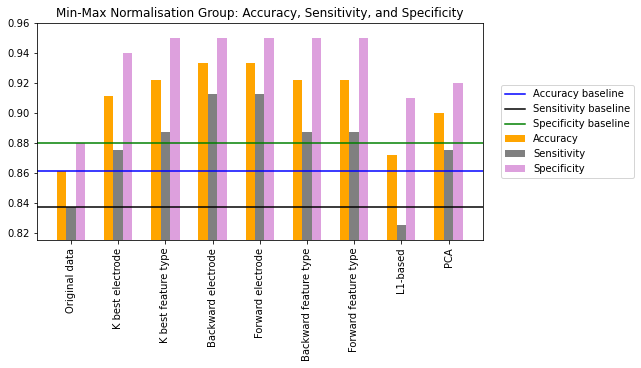

In [30]:
plot_results(results_ss)  # Use my function to plot each strategy's accuracy, sensitivity, and specificity in the standardisation group.
plot_results(results_mms, False)  # Use my function to plot each strategy's accuracy, sensitivity, and specificity in the min-max normalisation group.

Based on the above results, the best feature engineering strategy is to apply **standardisation** as feature scaling and **forward electrode elimination** as feature selection. For more info, please refer to the corresponding report.